<a href="https://colab.research.google.com/github/Shona173/codes/blob/main/3DSDF_OT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install POT
!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 16.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from google.colab import files
from matplotlib import animation
from IPython.display import HTML
import ot
import time

In [1]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [2]:
def ndot(a,b):
    return a[0]*b[0]-a[1]*b[1]

In [27]:
def sdf_sphere(p, r=0.5):
    p = p.copy()
    return np.sqrt(np.sum(p**2, axis=1)) - r

In [23]:
def sdf_box(p, b=[0.7,0.7,0.7]):
    p = p.copy()
    q = np.abs(p) - b
    return np.linalg.norm(np.maximum(q, 0.0)) + np.minimum(np.maximum(q[:,0], np.maximum(q[:,1], q[:,2])), 0.0)

In [40]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y, z = np.meshgrid(idx, idx,idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1)),z.reshape((-1,1))), 1)

    return V

In [42]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv

    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size,grid_size)

    return fv

(262144, 3)
(262144,)
(262144, 3)
(262144,)


TypeError: Invalid shape (64, 64, 64) for image data

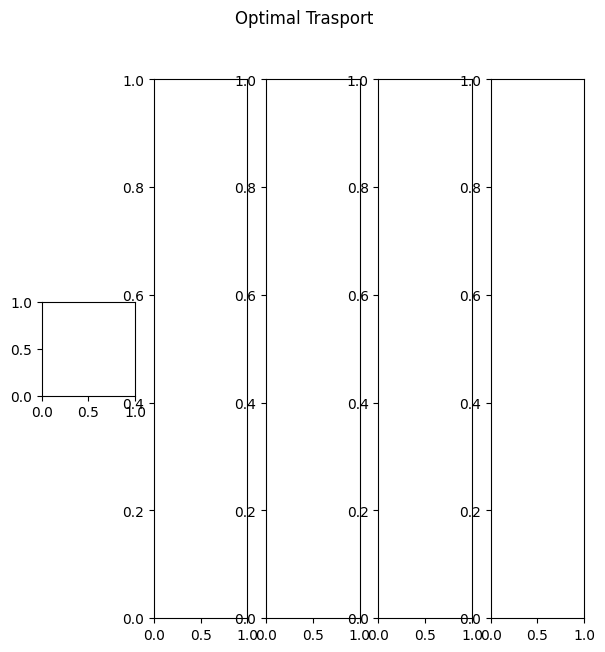

In [44]:
start=time.time()
grid_size = 64
grid = gen_grid(grid_size,-2.0,2.0)

# f1 and f2 are prob. distribution corresponding to f1 and f2
f1 = sample_and_normalize(sdf_sphere, grid, grid_size)
f2 = sample_and_normalize(sdf_sphere, grid, grid_size)

A = np.array([f1,f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("Optimal Trasport")
cm = "Blues"

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)

    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        # call to barycenter computation
        axes[i].imshow(
            ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm
        )
    axes[i].axis("off")
#Optimal Trasport
plt.tight_layout()
plt.show()
end=time.time()
print(end-start)